# WDSR

In [ ]:
## for colab, make sure it uses python 3.8
!sudo update-alternatives --config python3
!sudo apt install python3-pip

In [1]:
#COLAB environment setup:
!pip install tensorflow-gpu==2.3.1 tensorflow-addons==0.11.2 ## replace to !pip install tensorflow for CPU

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 320.4 MB 24 kB/s 
     |████████████████████████████████| 1.1 MB 11.3 MB/s 
     |████████████████████████████████| 459 kB 72.0 MB/s 
     |████████████████████████████████| 2.9 MB 51.3 MB/s 
     |████████████████████████████████| 20.1 MB 1.2 MB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      

In [2]:
!git clone https://github.com/IritaSee/super-resolution-colab.git

Cloning into 'super-resolution'...
remote: Enumerating objects: 408, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 408 (delta 0), reused 2 (delta 0), pack-reused 405
Receiving objects: 100% (408/408), 48.16 MiB | 40.52 MiB/s, done.
Resolving deltas: 100% (214/214), done.


In [3]:
%cd super-resolution

/content/super-resolution


In [1]:
!ls

 article.ipynb		        example_wdsr.ipynb
 data_engineering.ipynb         LICENSE
 data.py		        model
 dataset.md		        new_dataset
 demo			        __pycache__
 docs			        README.md
 environment.yml	        train.py
 example_edsr.ipynb	        utils.py
 example_srgan.ipynb	        weights
'example_wdsr depth 16.ipynb'   weights-wdsr-b-32-x4.tar.gz
'example_wdsr depth 32.ipynb'   weights-wdsr-b-32-x4.tar.gz.1


In [5]:
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.wdsr import wdsr_b
from train import WdsrTrainer

%matplotlib inline

In [4]:
# Number of residual blocks
# depth = 32
depth = 16
# depth = 64

# Super-resolution factor
scale = 4 #ini jangan di ganti, ngaruh ke dataset

# Downgrade operator
downgrade = 'bicubic'

In [7]:
# Location of model weights (needed for demo)
weights_dir = f'weights/wdsr-b-{depth}-x{scale}'
weights_file = os.path.join(weights_dir, 'weights_16_as_depth.h5')

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [8]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
div2k_train = DIV2K(scale=scale, subset='train', downgrade=downgrade)
div2k_valid = DIV2K(scale=scale, subset='valid', downgrade=downgrade)

In [9]:
train_ds = div2k_train.dataset(batch_size=16, random_transform=True)
valid_ds = div2k_valid.dataset(batch_size=1, random_transform=False, repeat_count=1)

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-wdsr-b-32-x4.tar.gz](https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz) and extract the archive in the project's root directory. This will create a `weights/wdsr-b-32-x4` directory containing the weights of the pre-trained model.

In [7]:
!wget https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz

--2023-06-21 21:57:35--  https://martin-krasser.de/sisr/weights-wdsr-b-32-x4.tar.gz
Resolving martin-krasser.de (martin-krasser.de)... 217.160.0.142, 2001:8d8:100f:f000::209
Connecting to martin-krasser.de (martin-krasser.de)|217.160.0.142|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2328140 (2.2M) [application/gzip]
Saving to: ‘weights-wdsr-b-32-x4.tar.gz.1’

weights-wdsr-b-32-x 100%[===================>]   2.22M  1.13MB/s    in 2.0s    

2023-06-21 21:57:39 (1.13 MB/s) - ‘weights-wdsr-b-32-x4.tar.gz.1’ saved [2328140/2328140]



In [8]:
! tar -xf weights-wdsr-b-32-x4.tar.gz

In [12]:
trainer = WdsrTrainer(model=wdsr_b(scale=scale, num_res_blocks=depth), 
                      checkpoint_dir=f'.ckpt/wdsr-b-{depth}-x{scale}')

In [13]:
# Train WDSR B model for 300,000 steps and evaluate model
# every 1000 steps on the first 10 images of the DIV2K
# validation set. Save a checkpoint only if evaluation
# PSNR has improved.
# uncomment code below to train!
trainer.train(train_ds,
              valid_ds.take(10),
              steps=300000, 
              evaluate_every=1000, 
              save_best_only=True)

1000/300000: loss = 5.014, PSNR = 35.934669 (152.65s)
2000/300000: loss = 2.567, PSNR = 37.799564 (137.75s)
3000/300000: loss = 2.213, PSNR = 38.849377 (136.51s)
4000/300000: loss = 2.072, PSNR = 39.296741 (136.52s)
5000/300000: loss = 1.956, PSNR = 39.547318 (136.49s)
6000/300000: loss = 1.869, PSNR = 39.840172 (136.57s)
7000/300000: loss = 1.831, PSNR = 40.072765 (136.49s)
8000/300000: loss = 1.767, PSNR = 39.725182 (136.63s)
9000/300000: loss = 1.727, PSNR = 40.167366 (136.59s)
10000/300000: loss = 1.687, PSNR = 40.406208 (136.42s)
11000/300000: loss = 1.653, PSNR = 40.410816 (136.56s)
12000/300000: loss = 1.639, PSNR = 40.493710 (136.36s)
13000/300000: loss = 1.611, PSNR = 40.741779 (136.23s)
14000/300000: loss = 1.606, PSNR = 40.590374 (136.48s)
15000/300000: loss = 1.568, PSNR = 40.779442 (136.52s)
16000/300000: loss = 1.556, PSNR = 40.962006 (136.43s)
17000/300000: loss = 1.545, PSNR = 41.003475 (136.32s)
18000/300000: loss = 1.540, PSNR = 41.106079 (136.28s)
19000/300000: loss 

In [14]:
# Restore from checkpoint with highest PSNR
trainer.restore()

Model restored from checkpoint at step 205000.


In [15]:
# Save weights to separate location (needed for demo)
trainer.model.save_weights(weights_file)

## Evaluation (PSNR Score)

In [16]:
# Evaluate model on full validation set
psnr = trainer.evaluate(valid_ds)
print(f'PSNR = {psnr.numpy():3f}')

PSNR = 42.010365


## Demo

In [17]:
model = wdsr_b(scale=scale, num_res_blocks=depth)
model.load_weights(weights_file)

In [18]:
from model import resolve_single
from utils import load_image, plot_sample
from PIL import Image
import numpy as np

def convert_and_plot(lr_image_path):
    lr = np.array(Image.open(lr_image_path).convert('RGB'))
    
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

In [19]:
from model import resolve_single
from utils import load_image, plot_sample

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    sr = resolve_single(model, lr)
    plot_sample(lr, sr)

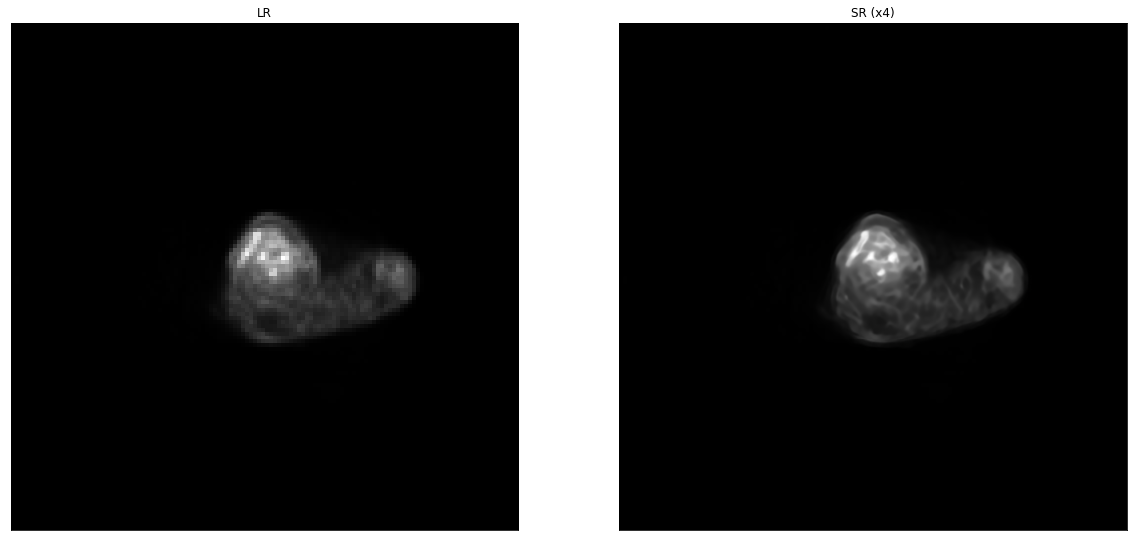

In [20]:
new_image = './new_dataset/PET-radiomics-challenges-kaggle/Training/1.3.6.1.4.1.14519.5.2.1.1707.8040.10059866353110167322451781.png'
convert_and_plot(new_image)

In [19]:
# !conda install -c conda-forge gcc=12.1.0


In [21]:
from skimage.metrics import structural_similarity as compare_ssim
import argparse
import imutils
import cv2
new_image = './new_dataset/Y-90/downscaled/0150x4.png'
# load the two input images
lr = np.array(Image.open(new_image).convert('RGB'))
sr = resolve_single(model, lr)
imageA = cv2.imread('./new_dataset/Y-90/normal/0150.png')
imageB = np.array(sr)
# convert the images to grayscale
grayA = cv2.cvtColor(imageA, cv2.COLOR_RGB2GRAY)
grayB = cv2.cvtColor(imageB, cv2.COLOR_RGB2GRAY)

# compute the Structural Similarity Index (SSIM) between the two
# images, ensuring that the difference image is returned
(score, diff) = compare_ssim(grayA, grayB, full=True)
diff = (diff * 255).astype("uint8")
print("SSIM: {}".format(score))

SSIM: 0.9768972750923017
